<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [131]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

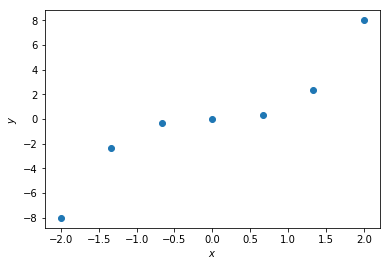

In [132]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

In [133]:
y, np.mean(y)

(array([-8.        , -2.37037037, -0.2962963 ,  0.        ,  0.2962963 ,
         2.37037037,  8.        ]), -2.5376526277146434e-16)

In [134]:
y_one_leafe = [np.mean(y)]*7

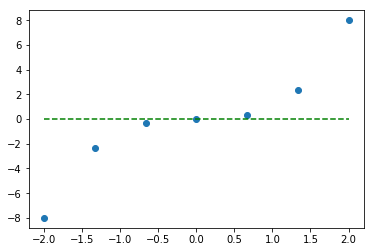

In [135]:
plt.plot(X, y, 'o', X, y_one_leafe,'g--');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

In [173]:
l1_mean = np.mean(y[X < 0])
r1_mean = np.mean(y[X >= 0])

l1_mean, r1_mean

(-3.5555555555555554, 2.666666666666666)

In [174]:
X_small_parts = np.linspace(-2,2,100)

def calculate_y_for_leaves(x):
    if x < 0:
        return l1_mean
    else:
        return r1_mean

calculatee_y_for_leaves = np.vectorize(calculate_y_for_leaves)
y_two_leaves = calculatee_y_for_leaves(X_small_parts)


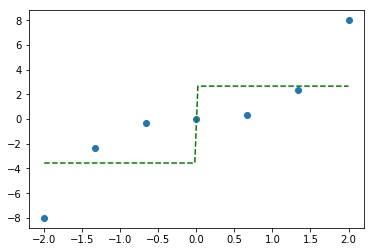

In [175]:
plt.plot(X, y, 'o', X_small_parts, y_two_leaves,'g--');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [139]:
def D(z):
    return np.sum((z - np.mean(z))**2)/len(z)


In [143]:
def Q(X, y, t):
    Xl = y[X < t]
    Xr = y[X >= t]
    
    return (D(y) - (len(Xl)/len(X))*D(Xl) - (len(Xr)/len(X))*D(Xr))

In [144]:
Q(np.array([1,3,45]),np.array([12,3,4]),12)

2.7222222222222214

In [145]:
t_array = np.linspace(-1.9, 1.9, 100)
q_array = np.empty(len(t_array))

for i in range(len(t_array)):
    q_array[i] = Q(X, y, t_array[i])
    
q_array

array([10.66666667, 10.66666667, 10.66666667, 10.66666667, 10.66666667,
       10.66666667, 10.66666667, 10.66666667, 10.66666667, 10.66666667,
       10.66666667, 10.66666667, 10.66666667, 10.66666667, 10.66666667,
       10.75445816, 10.75445816, 10.75445816, 10.75445816, 10.75445816,
       10.75445816, 10.75445816, 10.75445816, 10.75445816, 10.75445816,
       10.75445816, 10.75445816, 10.75445816, 10.75445816, 10.75445816,
       10.75445816, 10.75445816, 10.75445816,  9.48148148,  9.48148148,
        9.48148148,  9.48148148,  9.48148148,  9.48148148,  9.48148148,
        9.48148148,  9.48148148,  9.48148148,  9.48148148,  9.48148148,
        9.48148148,  9.48148148,  9.48148148,  9.48148148,  9.48148148,
        9.48148148,  9.48148148,  9.48148148,  9.48148148,  9.48148148,
        9.48148148,  9.48148148,  9.48148148,  9.48148148,  9.48148148,
        9.48148148,  9.48148148,  9.48148148,  9.48148148,  9.48148148,
        9.48148148,  9.48148148, 10.75445816, 10.75445816, 10.75

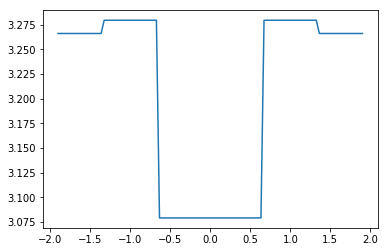

In [ ]:


def regression_var_criterion(X, y, t):
    # 
    pass

In [ ]:
# Ваш код здесь

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Ответ: нет, не оптимально

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [168]:
def calculate_y_for_7_leaves(x):
    if x < -1.5:
        return np.mean(y[X < -1.5])
    elif x < 0:
        return np.mean(y[(-1.5 <= X) & (X < 0)])
    elif x < 1.5:
        return np.mean(y[(0 <= X) & (X < 1.5)])
    else:
        return np.mean(y[X >= 1.5])
        
    
    
    

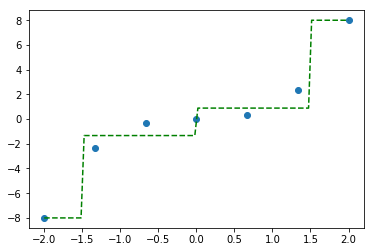

In [171]:
calculate_y_for_7_leaves = np.vectorize(calculate_y_for_7_leaves)
y_7_leaves = calculate_y_for_7_leaves(X_small_parts)
plt.plot(X, y, 'o', X_small_parts, y_7_leaves, 'g--');


**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

Ответ: 7

In [176]:
from sklearn.tree import DecisionTreeRegressor

In [207]:
model = DecisionTreeRegressor(max_depth=1)
model = model.fit(X.reshape(-1,1), y)

In [208]:
y_predicted = model.predict(np.linspace(-2,2,100).reshape(-1,1))

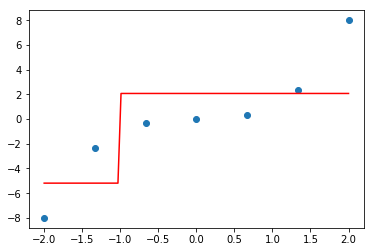

In [209]:
plt.plot(X,y,'o',np.linspace(-2,2,100), y_predicted, 'r-');

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [210]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [211]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [223]:
df.age = (df.age/365.25).astype(np.int)

In [227]:
df = pd.get_dummies(df, columns=['cholesterol', 'gluc'])

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [240]:
X = df.drop(['cardio'], axis=1)
y = df['cardio']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17)

In [241]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((49000, 15), (21000, 15), (49000,), (21000,))

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [245]:
model = DecisionTreeClassifier(max_depth=3, random_state=17).fit(X_train, y_train)

In [261]:
X_train.columns.values

array(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'smoke',
       'alco', 'active', 'cholesterol_1', 'cholesterol_2',
       'cholesterol_3', 'gluc_1', 'gluc_2', 'gluc_3'], dtype=object)

In [279]:
export_graphviz(model, out_file='hw3_q2_tree.dot', feature_names=['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'smoke',
       'alco', 'active', 'cholesterol_1', 'cholesterol_2',
       'cholesterol_3', 'gluc_1', 'gluc_2', 'gluc_3'], filled=True)

In [281]:
!dot -Tpng 'hw3_q2_tree.dot' -o 'hw3_q21_tree.png'

<img src='/notebooks/jupyter_russian/homeworks/hw3_q21_tree.png'/>

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Ответ: age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [369]:
y_test_predicted = model.predict(X_valid)
accuracy_score(y_valid, y_test_predicted)

0.7212857142857143

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [370]:
tree = DecisionTreeClassifier(random_state=17)
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [371]:
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 6}, 0.7322244897959184)

In [372]:
accuracy_score(y_valid, tree_grid.predict(X_valid))

0.7256666666666667

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

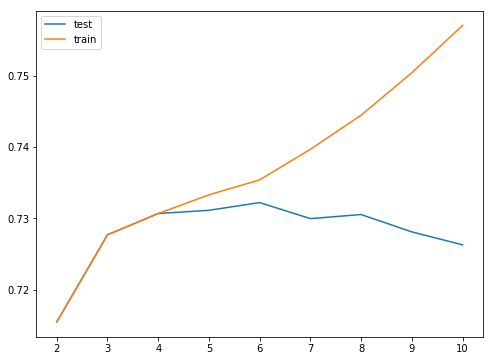

In [389]:
tree_depth = [x['max_depth'] for x in tree_grid.cv_results_['params']]
test_scores = tree_grid.cv_results_['mean_test_score']
train_scores = tree_grid.cv_results_['mean_train_score']

plt.figure(figsize=(8,6))
plt.plot(tree_depth, test_scores, tree_depth, train_scores);
plt.legend(labels=['test','train']);

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [306]:
tree_grid.best_params_, accuracy_score(y_valid, tree_grid.predict(X_valid))

({'max_depth': 6}, 0.7256666666666667)

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

Ответ: да, нет

In [311]:
acc1 = accuracy_score(y_valid, y_test_predicted)
acc2 = accuracy_score(y_valid, tree_grid.predict(X_valid))
100 * (acc2 - acc1)/acc1
               

0.6073809995378613

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

Ответ: Верхнее артериальное давление от 140 до 160 (мм рт.ст.)

In [314]:
df['male'] = df.gender.map({1:0,2:1})

In [322]:
def get_age_range(age):
    if 45 <= age < 50:
        return 1
    elif 50 <= age < 55:
        return 2
    elif 55 <= age < 60:
        return 3
    elif 60 <= age < 65:
        return 4
    else:
        return 0

In [323]:
df['age_category'] = df.age.map(get_age_range)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,male,age_category
id,,,,,,,,,,,,,,,,,,
0,50,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0,1,2
1,55,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0,0,3
2,51,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0,0,2
3,48,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0,1,1
4,47,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0,0,1


In [324]:
def get_ap_hi_category(ap_hi):
    if 120 <= ap_hi < 140:
        return 1
    elif 140 <= ap_hi < 160:
        return 2
    elif 160 <= ap_hi < 180:
        return 3
    else:
        return 0

In [325]:
df['ap_hi_category'] = df.ap_hi.map(get_ap_hi_category)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,male,age_category,ap_hi_category
id,,,,,,,,,,,,,,,,,,,
0,50,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0,1,2,0
1,55,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0,0,3,2
2,51,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0,0,2,1
3,48,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0,1,1,2
4,47,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0,0,1,0


In [330]:
df = pd.get_dummies(df, columns=['age_category', 'ap_hi_category'], drop_first=True)

In [333]:
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'smoke', 'alco',
       'active', 'cardio', 'cholesterol_1', 'cholesterol_2', 'cholesterol_3',
       'gluc_1', 'gluc_2', 'gluc_3', 'male', 'age_category_1',
       'age_category_2', 'age_category_3', 'age_category_4',
       'ap_hi_category_1', 'ap_hi_category_2', 'ap_hi_category_3'],
      dtype='object')

In [350]:
y_5 = df.cardio
X_5 = df[['cholesterol_1', 'cholesterol_2', 'cholesterol_3', 'male', 'smoke', 
       'age_category_1','age_category_2', 'age_category_3', 'age_category_4',
       'ap_hi_category_1', 'ap_hi_category_2', 'ap_hi_category_3']]

In [351]:
tree_5 = DecisionTreeClassifier(max_depth=3, random_state=17)
tree_5.fit(X_5, y_5)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [354]:
export_graphviz(tree_5, out_file='hw3_q5_tree.dot', feature_names=X_5.columns, filled=True)

In [355]:
!dot -Tpng 'hw3_q5_tree.dot' -o 'hw3_q5_tree.png'

<img src='hw3_q5_tree.png' />

In [357]:
X_train_5, X_valid_5, y_train_5, y_valid_5 = train_test_split(X_5, y_5, test_size=0.3, random_state=17)

In [358]:
X_train_5.shape, X_valid_5.shape, y_train_5.shape, y_valid_5.shape

((49000, 12), (21000, 12), (49000,), (21000,))

In [360]:
tree_5 = DecisionTreeClassifier(random_state=17)
tree_params_5 = {'max_depth': list(range(2, 20))}

tree_grid_5 = GridSearchCV(tree_5, tree_params_5, cv=5, n_jobs=-1, verbose=True)
tree_grid_5.fit(X_train_5, y_train_5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

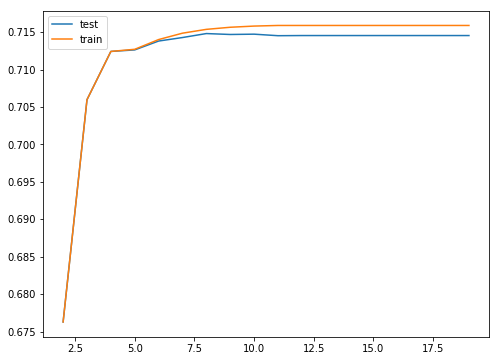

In [390]:
tree_depth = [x['max_depth'] for x in tree_grid_5.cv_results_['params']]
test_scores = tree_grid_5.cv_results_['mean_test_score']
train_scores = tree_grid_5.cv_results_['mean_train_score']

plt.figure(figsize = (8,6))
plt.plot(tree_depth, test_scores, tree_depth, train_scores)
plt.legend(labels=['test', 'train']);

In [368]:
tree_grid_5.best_params_, tree_grid_5.best_score_, accuracy_score(y_valid_5, tree_grid_5.predict(X_valid_5))

({'max_depth': 8}, 0.7148163265306122, 0.7140952380952381)